In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans  # Mini-Batch K-Means clustering.
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.datasets import make_blobs

# Generate sample data
np.random.seed(0)
batch_size = 45
centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers,
                            cluster_std=0.7)  # Generate isotropic Gaussian blobs for clustering.
X.shape

(3000, 2)

In [2]:
labels_true

array([1, 1, 2, ..., 2, 1, 0])

C:\Users\duanm\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


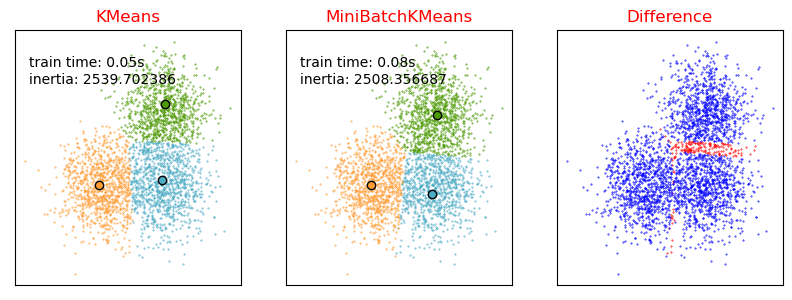

In [3]:
# Compute clustering with Means
k_means = KMeans(init='k-means++',  # 初始化方法(推荐默认init='k-means++')
                 n_clusters=3,  # 聚类簇数(默认n_clusters=8)
                 n_init=10,
                 # Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.
                 max_iter=300,  # 执行一次k-means算法所进行的最大迭代次数(默认max_iter=300) 
                 tol=1e4,  # Relative tolerance with regards to inertia to declare convergence(默认tol=1e4)
                 random_state=1)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0  # 获取fit函数运行时间

# Compute clustering with MiniBatchKMeans
mbk = MiniBatchKMeans(init='k-means++',  # 初始化方法(推荐默认init='k-means++')
                      n_clusters=3,  # 聚类簇数(默认n_clusters=8)
                      batch_size=batch_size,  # Size of the mini batches(默认batch_size=100)
                      n_init=10,
                      # Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.
                      tol=1e4,  # Relative tolerance with regards to inertia to declare convergence(默认tol=1e4)
                      max_iter=300,  # 执行一次k-means算法所进行的最大迭代次数(默认max_iter=100)
                      random_state=1)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0

fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ['#4EACC5', '#FF9C34', '#4E9A06']

k_means_cluster_centers = k_means.cluster_centers_  # Coordinates of cluster centers.
order = pairwise_distances(k_means.cluster_centers_, mbk.cluster_centers_).argmin(axis=1)
mbk_means_cluster_centers = mbk.cluster_centers_[order]  # 使两种聚类方法的聚类中心两两一致

k_means_labels = pairwise_distances(X, k_means_cluster_centers).argmin(axis=1)  # 以每个样本最近的聚类中心的编号(0,1,2)作为样本标签
mbk_means_labels = pairwise_distances(X, mbk_means_cluster_centers).argmin(axis=1)

# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.scatter(X[my_members, 0], X[my_members, 1], s=0.15, color=col)  # 绘制聚类点
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)  # 绘制聚类中心
ax.set_title('KMeans', color='red')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, 'train time: %.2fs\ninertia: %f' % (
    t_batch,
    k_means.inertia_))  # Sum of squared distances of samples to their closest cluster center.

# MiniBatchKMeans
ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    ax.scatter(X[my_members, 0], X[my_members, 1], s=0.15, color=col)
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
ax.set_title('MiniBatchKMeans', color='red')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, 'train time: %.2fs\ninertia: %f' %
         (t_mini_batch,
          mbk.inertia_))  # Sum of squared distances of samples to their closest cluster center.

different = (mbk_means_labels == 4)  # 将different初始化为值全为False的数组
ax = fig.add_subplot(1, 3, 3)
for k in range(n_clusters):
    different += ((k_means_labels == k) != (mbk_means_labels == k))  # 添加两种聚类方法不同的点

identic = np.logical_not(different)  # 转换Ture/False
ax.scatter(X[different, 0], X[different, 1], s=0.15, color='r')  # 绘制两种聚类方法聚类结果不同的点
ax.scatter(X[identic, 0], X[identic, 1], s=0.15, color='b')
ax.set_title('Difference', color='red')
ax.set_xticks(())
ax.set_yticks(())
plt.show()